<h1><center>The Evolution of Popular Music over Recent Years</center></h1>
<h3><center>By Noah Griff, Timmy Trapaidze, and Christian Tonti</center></h3>

![Billboard Hot 100 1988](https://media.npr.org/assets/img/2013/08/01/1988---billboard-hot-100-singles-chart_wide-1181692be74853bd0bf8fa888ae2733ae79ac585.jpg?s=1400)
## Table of Contents
1. [Introduction](#introduction)
    - [Useful Resources](#resources)
2. [Data Collection and Cleaning](#collection)
3. [Analysis](#analysis)


## Introduction<a name='introduction'></a>
Over the years, music has become an increasingly large part of our daily lives. With each technological development, from public radio and cassette tapes to music streaming services and fully wireless earbuds, we have had more and more ways to listen to the songs we love. While a form of cultural and personal expression, popular music also provides a common ground on which people can connect. When a song comes on at an event or party that everybody knows the words to, people sing along, have fun, and have a great time. So we started thinking: while music-listening technology has changed over the years, how has what the general population considers enjoyable evolved? What attributes of a song make it popular, and is it that different a couple decades ago?  
  
Luckily for us, a company has been keeping track of the most popular songs since the latter half of the 20th century. Starting in August of 1958, Billboard has been publishing the Hot 100 songs every week, year and decade, allowing us to get a snapshot of what popular music has looked like over time.  
  
In this project, we will be using Billboard's yearly Hot 100 charts from 1971 to present along with Spotify's Web API in order to conduct analysis on the evolution of popular music in recent years. Spotify's API has an endpoint called audio-analysis, which returns analytical information about a song, such as its tempo, key, danceability, and energy. Using all of this information, we will analyze if any of these features have changed over time, as well as if there is a correlation between them and the song's rank within the chart.

### Useful Resources<a name='resources'></a>
Here is a list of some useful, helpful, or interesting resources related to our work:
- [The creation, rise, and rule of Billboard's Hot 100 - NPR](https://www.npr.org/sections/therecord/2013/08/16/207879695/how-the-hot-100-became-americas-hit-barometer)
- [Why music is getting louder - Curiosity.com](https://curiosity.com/topics/why-music-is-getting-louder-curiosity/)
- [Research paper on the evolution of popular music](https://doi.org/10.1098/rsos.150081)
- [Spotify Web API Reference](https://developer.spotify.com/documentation/web-api/reference/)
    - [Audio analysis endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)
--------
For this project, we will be using Python 3 along with the following libraries:
- [spotipy](https://spotipy.readthedocs.io/en/latest/#) to efficiently query the Spotify Web API with Python
- [urllib.request](https://docs.python.org/3/library/urllib.request.html) to get the HTML from the websites which have the Billboard Hot 100 charts
- [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to help us scrape the Billboard Hot 100 charts by reading through and analyzing the HTML files
- [pandas](https://pandas.pydata.org/pandas-docs/stable/) to store, organize, and manipulate all of our data using powerful DataFrame objects
- [numpy](https://docs.scipy.org/doc/numpy/reference/index.html) to add NaN values as well as some extra functions
- [seaborn](https://seaborn.pydata.org/) to easily and beautifully visualize our findings
- [matplotlib.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) to further manipulate the appearance of our graphs
  
We begin by importing these libraries here:

In [1]:
# install spotipy if not installed
!pip install spotipy
# imports
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import time

## Data Collection and Cleaning<a name='collection'></a>
The first thing we must do is to obtain the data we wish to analyze. This includes getting the top 100 songs from every year, finding those songs on Spotify, and then obtaining the audio analysis for each song.  
  
Here, we use urllib.request, and pandas.read_html in order to get the Billboard Hot 100 songs for each year. For each year between 1970 and 2020, we query Wikipedia (Billboard's site had query limits and was missing data from 1992-2006) for the chart and read the HTML table into a pandas DataFrame. We then append that year's list to a larger frame containing every song from each year:

In [2]:
# perform an initial read for 1970 to start off the larger dataframe
page = Request("https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970",headers={'User-Agent': 'Mozilla/5.0'})
html = urlopen(page).read()
wiki = pd.read_html(html)[0]

for i in range(1971,2020):
    #2012 and 2013 just did not want to be scrapable
    if(i != 2012 and i != 2013):
        # create list for year column in the dataframe
        year = [i] * 100
        # open and read the page
        page = Request("https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"+str(i),headers={'User-Agent': 'Mozilla/5.0'})
        html = urlopen(page).read()
        # read in the table of songs
        cur = pd.read_html(html)[0]
        # add year column
        cur['year'] = year
        # append to larger dataframe
        wiki = wiki.append(cur,ignore_index=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [3]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 7 columns):
0            0 non-null float64
1            1 non-null object
Artist(s)    4700 non-null object
No.          3200 non-null float64
Title        4700 non-null object
year         4700 non-null float64
№            1500 non-null float64
dtypes: float64(4), object(3)
memory usage: 257.2+ KB


Cool! We now have 4700 songs in our DataFrame. But as you can see, we have two redundant/empty columns labeled 0 and 1. On top of this, we also see that some years use 'No.' for the rank, but others use the numero symbol (№). If we take a look at the Wikipedia pages, we see that in 2002, № replaced No. But these both mean rank, so we will combine these into a single column:

In [4]:
# create empty list for rank column
rank = []
# replace NaNs with 0
wiki = wiki.fillna(0)

# append the rank for the year
for i,row in wiki.iterrows():
    # since one of these will be 0, adding them together produces the real rank
    no = row['№']
    num = row['No.'] 
    rank.append(no + num)

# add the rank column and drop the previous ones
wiki['rank'] = rank
wiki = wiki.drop(columns=['No.','№'])
# delete empty row from the HTML read-in
wiki = wiki.drop(wiki.index[0])
# set the type of year and rank to integers
wiki['year'] = wiki['year'].astype('int64')
wiki['rank'] = wiki['rank'].astype('int64')
# rename some columns to be easier to use
wiki = wiki.rename(columns={"Artist(s)": "artist", "Title":"song"})
wiki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700 entries, 1 to 4700
Data columns (total 6 columns):
0         4700 non-null float64
1         4700 non-null object
artist    4700 non-null object
song      4700 non-null object
year      4700 non-null int64
rank      4700 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 257.0+ KB


Looking good! But we forgot to drop those first two empty columns, so we'll do that now:

In [5]:
wiki = wiki.drop(columns=[0,1], axis = 1)
wiki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4700 entries, 1 to 4700
Data columns (total 4 columns):
artist    4700 non-null object
song      4700 non-null object
year      4700 non-null int64
rank      4700 non-null int64
dtypes: int64(2), object(2)
memory usage: 183.6+ KB


Perfect! Let's take a look at some of the data:

In [6]:
data = wiki.loc[wiki['year'] > 1970]
data.head()

,artist,song,year,rank
1,Three Dog Night,"""Joy to the World""",1971,1
2,Rod Stewart,"""Maggie May""/""Reason to Believe""",1971,2
3,Carole King,"""It's Too Late""/""I Feel the Earth Move""",1971,3
4,The Osmonds,"""One Bad Apple""",1971,4
5,Bee Gees,"""How Can You Mend a Broken Heart""",1971,5


Now it's time for the second part of data collection -- finding the songs on Spotify. For this, we will be using spotipy, a python libary which wraps the Spotify Web API for easier access. To start, we must initialize a connection:

In [7]:
# generated authorization tokens
SPOTIPY_CLIENT_ID='dfc90bae743943689c070c2f0b7fd7e0'
SPOTIPY_CLIENT_SECRET='477f42668a624f6e875a5399643b8c00'

# passes in the credentials for the cleint credential flow
client_credentials_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID,SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Now we can search for our songs using functions from spotipy. The function we will use is sp.search, which is similar to typing into the search bar in the Spotify app. We specify that we want tracks, and store the dictionary response into a results list.

In [8]:
# empty list for storing responses
results = []
# search for each song name in the dataframe
for index, row in data.iterrows():
    results.append(sp.search(q=row.song,type='track'))

We have now stored the search results for each song. Now, we must query the Spotify Web API for the audio analysis of each song. To do this, we use the spotipy audio_features function. Note that if the song cannot be found on Spotify, the entire row is dropped from the data.

In [9]:
# index for dropping and empty list for storing response dictionaries
index = 0
analyses = []
# go through each search query result
for result in results:
    # if the items key doesnt exist, bad data -- drop row and continue to next row
    if 'items' in result['tracks']:     
        # if the dictionary length is 0, drop row and continue
        if len(result['tracks']['items']) > 0:
            # search for audio features of current song. pull the first result 
            analysis = sp.audio_features(result['tracks']['items'][0]['id'])
            analyses.append(analysis)
        else:
            data.drop(index, inplace=True)
            continue
    else:
        data.drop(index, inplace=True)
        continue
        
    index += 1

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


Now we will break down the each analysis into its components and store them as columns in the dataframe. Not only does each contain analysis of audio features, but also important information such as the track URI.

In [10]:
# empty lists for new columns
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = [] 
valence = [] 
tempo = [] 
type_feature = [] 
song_id = []
uri = []
track_href = []
analysis_url = []
duration_ms = []
time_signature = []
name = []

# index for dropping
index = 0

for analysis in analyses:
    # the audio features method returned a none type, drop the row
    if analysis[0] is None:
        data.drop(index, inplace=True)
    else:
        # append all the data to column lists
        name.append(row.song)
        danceability.append(analysis[0]['danceability'])
        energy.append(analysis[0]['energy'])
        key.append(analysis[0]['key'])
        loudness.append(analysis[0]['loudness'])
        mode.append(analysis[0]['mode'])
        speechiness.append(analysis[0]['speechiness'])
        acousticness.append(analysis[0]['acousticness'])
        instrumentalness.append(analysis[0]['instrumentalness'])
        liveness.append(analysis[0]['liveness'])
        valence.append(analysis[0]['valence'])
        tempo.append(analysis[0]['tempo'])
        type_feature.append(analysis[0]['type'])
        song_id.append(analysis[0]['id'])
        uri.append(analysis[0]['uri'])
        track_href.append(analysis[0]['track_href'])
        analysis_url.append(analysis[0]['analysis_url'])
        duration_ms.append(analysis[0]['duration_ms'])
        time_signature.append(analysis[0]['time_signature'])  
    index += 1

# add all the new columns to the dataframe
data['danceability'] = danceability
data['energy'] = energy
data['key'] = key
data['loudness'] = loudness
data['mode'] = mode
data['speechiness'] = speechiness
data['acousticness'] = acousticness
data['instrumentalness'] = instrumentalness
data['liveness'] = liveness
data['valence'] = valence
data['tempo'] = tempo
data['type_feature'] = type_feature
data['song_id'] = song_id
data['uri'] = uri
data['track_href'] = track_href
data['analysis_url'] = analysis_url
data['duration_ms'] = duration_ms
data['time_signature'] = time_signature

In [11]:
data.head()

,artist,song,year,rank,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type_feature,song_id,uri,track_href,analysis_url,duration_ms,time_signature
1,Three Dog Night,"""Joy to the World""",1971,1,0.553,0.337,10,-10.334,1,0.0300,...,0.1130,0.662,101.918,audio_features,1VuAamHM7P3VQQEXYGG3Uu,spotify:track:1VuAamHM7P3VQQEXYGG3Uu,https://api.spotify.com/v1/tracks/1VuAamHM7P3V...,https://api.spotify.com/v1/audio-analysis/1VuA...,84987,4
3,Carole King,"""It's Too Late""/""I Feel the Earth Move""",1971,3,0.566,0.585,2,-8.733,1,0.0362,...,0.0911,0.567,129.475,audio_features,7hBTWJwdCkZt7IjUsENqmv,spotify:track:7hBTWJwdCkZt7IjUsENqmv,https://api.spotify.com/v1/tracks/7hBTWJwdCkZt...,https://api.spotify.com/v1/audio-analysis/7hBT...,350147,4
4,The Osmonds,"""One Bad Apple""",1971,4,0.600,0.567,0,-7.163,1,0.0398,...,0.2130,0.920,101.041,audio_features,50UoJUrslRVqG0cg6uboyn,spotify:track:50UoJUrslRVqG0cg6uboyn,https://api.spotify.com/v1/tracks/50UoJUrslRVq...,https://api.spotify.com/v1/audio-analysis/50Uo...,164973,4
5,Bee Gees,"""How Can You Mend a Broken Heart""",1971,5,0.458,0.421,4,-6.960,1,0.0403,...,0.0705,0.368,146.598,audio_features,6lUXneXZ9jc3HSMHgd8oqh,spotify:track:6lUXneXZ9jc3HSMHgd8oqh,https://api.spotify.com/v1/tracks/6lUXneXZ9jc3...,https://api.spotify.com/v1/audio-analysis/6lUX...,383503,3
6,Paul Revere & the Raiders,"""Indian Reservation (The Lament of the Cheroke...",1971,6,0.639,0.385,2,-13.253,1,0.0759,...,0.0873,0.209,131.714,audio_features,3mDOHVY9MWZOTODSNF5GBj,spotify:track:3mDOHVY9MWZOTODSNF5GBj,https://api.spotify.com/v1/tracks/3mDOHVY9MWZO...,https://api.spotify.com/v1/audio-analysis/3mDO...,171933,4


Great! We are now done with the collection and cleaning of our data. We can now use our data in analysis without having to worry about inconsistencies or nonexistent values.

## Analysis<a name='analysis'></a>

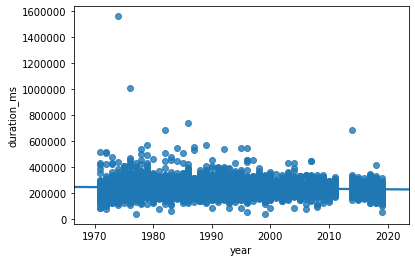

In [12]:
sns.regplot(x=data['year'],y=data['duration_ms'])

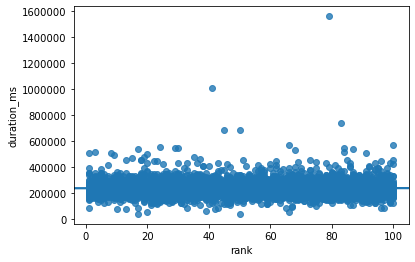

In [13]:
sns.regplot(x=data['rank'],y=data['duration_ms'])

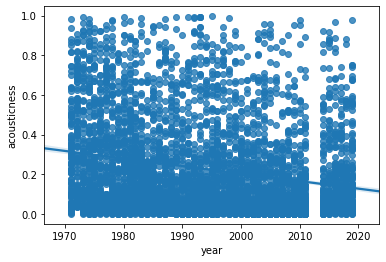

In [14]:
sns.regplot(x=data['year'],y=data['acousticness'])

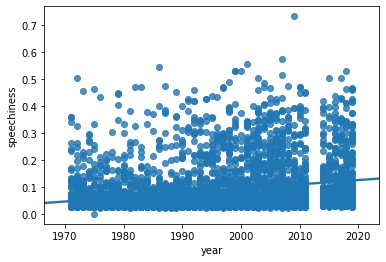

In [15]:
sns.regplot(x=data['year'],y=data['speechiness'])

In [16]:
grouped = data.groupby('year',as_index = False).mean()
grouped.head()


,year,rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1971,50.918367,0.585490,0.585415,4.806122,-9.695684,0.714286,0.064344,0.331709,0.035202,0.156188,0.656673,116.031173,206402.479592,3.94898
1,1972,50.500000,0.587790,0.548344,5.200000,-9.702650,0.740000,0.066357,0.401229,0.038205,0.182693,0.627022,121.754910,216849.780000,3.94000
2,1973,50.500000,0.600591,0.576703,5.280000,-10.017580,0.700000,0.061200,0.343584,0.057322,0.174489,0.676807,121.062880,230446.630000,3.95000
3,1974,50.500000,0.590550,0.593680,5.120000,-9.403870,0.830000,0.062343,0.348557,0.016483,0.195966,0.602665,116.840310,237011.880000,3.90000
4,1975,50.500000,0.604970,0.579202,5.250000,-9.710470,0.800000,0.059326,0.309382,0.032832,0.192812,0.624714,113.982830,229086.440000,3.91000


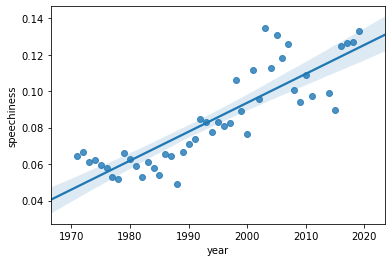

In [17]:

sns.regplot(x=grouped['year'] , y = grouped['speechiness'])

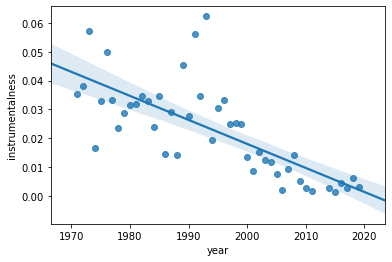

In [18]:
sns.regplot(x=grouped['year'], y= grouped['instrumentalness'])

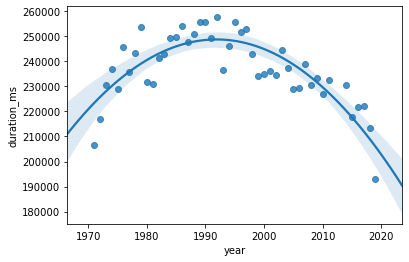

In [19]:
# The average length of a top 100 song has decreased by about 30 seconds from about 4 minutes to about 3 and a half minutes
sns.regplot(x=grouped['year'], y = grouped['duration_ms'],order=2)

In [20]:
nines = data.loc[data['year'] < 1996]
nines = nines.loc[nines['year'] >= 1990]
nines = nines.loc[nines['rank'] == 1]
nines.head()

,artist,song,year,rank,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type_feature,song_id,uri,track_href,analysis_url,duration_ms,time_signature
1901,Wilson Phillips,"""Hold On""",1990,1,0.691,0.602,9,-6.807,0,0.2090,...,0.0637,0.685,151.987,audio_features,5qDsijQM75KTdv3RtSPx91,spotify:track:5qDsijQM75KTdv3RtSPx91,https://api.spotify.com/v1/tracks/5qDsijQM75KT...,https://api.spotify.com/v1/audio-analysis/5qDs...,189480,4
2001,Bryan Adams,"""(Everything I Do) I Do It for You""",1991,1,0.526,0.365,1,-12.605,1,0.0280,...,0.0618,0.253,131.253,audio_features,6eBK3edMW7bEzecF1eCezc,spotify:track:6eBK3edMW7bEzecF1eCezc,https://api.spotify.com/v1/tracks/6eBK3edMW7bE...,https://api.spotify.com/v1/audio-analysis/6eBK...,394133,4
2101,Boyz II Men,"""End of the Road""",1992,1,0.373,0.717,1,-5.833,0,0.0830,...,0.1140,0.293,109.977,audio_features,24BNgrtp6Fag4M5BQPEgsV,spotify:track:24BNgrtp6Fag4M5BQPEgsV,https://api.spotify.com/v1/tracks/24BNgrtp6Fag...,https://api.spotify.com/v1/audio-analysis/24BN...,162981,5
2201,Whitney Houston,"""I Will Always Love You""",1993,1,0.306,0.214,4,-12.518,1,0.0356,...,0.0839,0.108,66.980,audio_features,4eHbdreAnSOrDDsFfc4Fpm,spotify:track:4eHbdreAnSOrDDsFfc4Fpm,https://api.spotify.com/v1/tracks/4eHbdreAnSOr...,https://api.spotify.com/v1/audio-analysis/4eHb...,271093,4
2301,Ace of Base,"""The Sign""",1994,1,0.516,0.595,5,-4.630,1,0.0313,...,0.1090,0.222,119.972,audio_features,5Ohxk2dO5COHF1krpoPigN,spotify:track:5Ohxk2dO5COHF1krpoPigN,https://api.spotify.com/v1/tracks/5Ohxk2dO5COH...,https://api.spotify.com/v1/audio-analysis/5Ohx...,340707,4


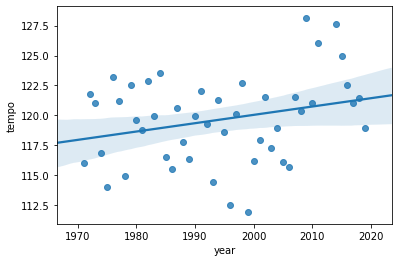

In [21]:
sns.regplot(x=grouped['year'], y = grouped['tempo'])

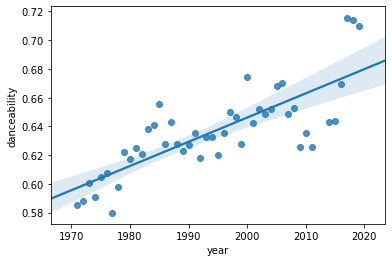

In [22]:
# Songs Have been getting more dancable
sns.regplot(x=grouped['year'], y = grouped['danceability'])

In [23]:
byRank = data.groupby('rank',as_index=False).mean()
byRank.head()

,rank,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,1994.255319,0.636660,0.592413,4.659574,-8.220851,0.787234,0.082506,0.251095,0.013259,0.171183,0.569064,117.741021,237233.446809,3.936170
1,2,1994.760870,0.694391,0.631267,4.695652,-7.161022,0.673913,0.067702,0.239075,0.028735,0.131620,0.637826,121.839565,236652.369565,4.000000
2,3,1994.255319,0.655681,0.610000,4.957447,-7.774064,0.680851,0.052511,0.259891,0.028498,0.165823,0.579674,114.048149,245526.914894,3.851064
3,4,1994.255319,0.666106,0.607511,4.382979,-7.993809,0.723404,0.073938,0.261921,0.030680,0.154296,0.573553,123.909298,235930.361702,3.893617
4,5,1994.217391,0.655870,0.660261,4.869565,-7.706130,0.608696,0.081517,0.178058,0.002683,0.190943,0.573376,117.322370,249153.217391,3.956522


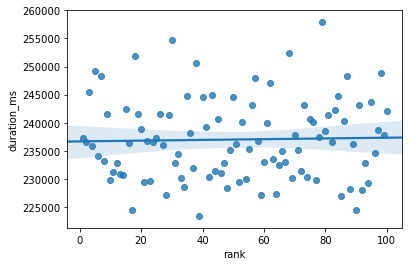

In [24]:
sns.regplot(byRank['rank'],byRank['duration_ms'])

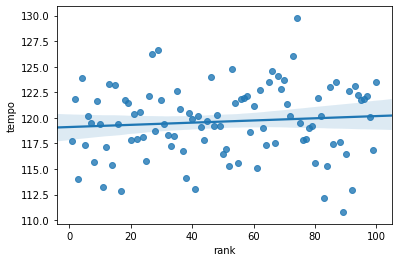

In [25]:
sns.regplot(byRank['rank'],byRank['tempo'])

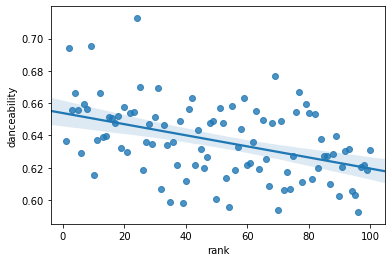

In [26]:
# Songs have been getting slowly less danceable
sns.regplot(byRank['rank'],byRank['danceability'])

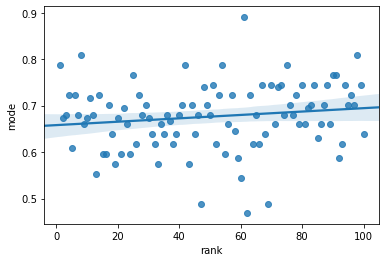

In [27]:
sns.regplot(byRank['rank'],byRank['mode'])

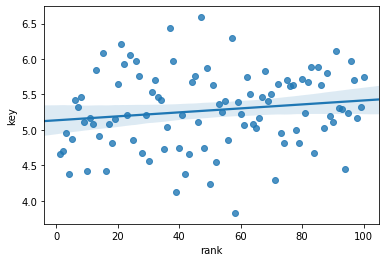

In [28]:
sns.regplot(byRank['rank'],byRank['key'])

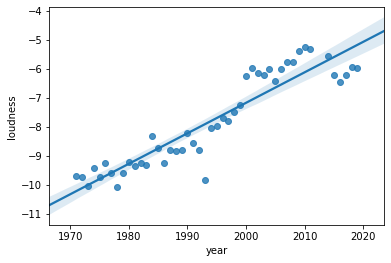

In [29]:
'''
Songs have been getting louder
https://curiosity.com/topics/why-music-is-getting-louder-curiosity/
'''

sns.regplot(grouped['year'],grouped['loudness'])

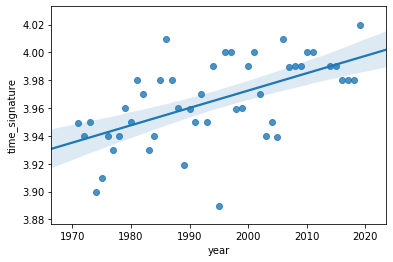

In [30]:
sns.regplot(grouped['year'],grouped['time_signature'])

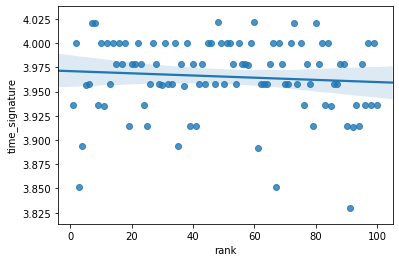

In [31]:
sns.regplot(byRank['rank'],byRank['time_signature'])

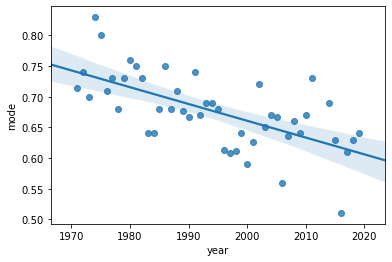

In [32]:
# Over the years a song is more likely to be minor
sns.regplot(grouped['year'],grouped['mode'])

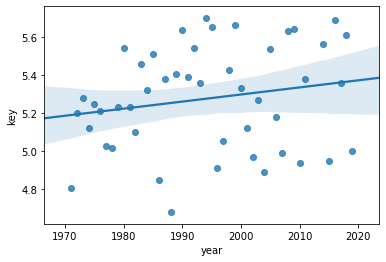

In [33]:
sns.regplot(grouped['year'],grouped['key'])

<h1><center>The Titans of Popular Music</center></h1>

In [34]:

data.head()
topArt = data['artist'].value_counts().to_frame(name='Num_Songs')
topArt = topArt.loc[topArt['Num_Songs'] > 9]
artID = []
genres = []
for i,row in topArt.iterrows():
    result = sp.search(q=i,type='artist')
    artID.append(result['artists']['items'][0]['id'])
    genres.append(result['artists']['items'][0]['genres'])

In [35]:

topArt['artID'] = artID
topArt['genres'] = genres

topArt

,Num_Songs,artID,genres
Madonna,35,6tbjWDEIzxoDsBA1FuhfPW,"[dance pop, pop]"
Elton John,26,3PhoLpVuITZKcymswpck5b,"[glam rock, mellow gold, piano rock]"
Janet Jackson,24,4qwGe91Bz9K2T8jXTZ815W,"[dance pop, hip pop, neo soul, new jack swing,..."
Mariah Carey,23,4iHNK0tOyZPYnBU7nGAgpQ,"[dance pop, pop, r&b, urban contemporary]"
Michael Jackson,22,3fMbdgg4jU18AjLCKBhRSm,"[pop, r&b, soul]"
Taylor Swift,20,06HL4z0CvFAxyc27GXpf02,"[pop, post-teen pop]"
Whitney Houston,19,6XpaIBNiVzIetEPCWDvAFP,"[dance pop, pop, r&b]"
Pink,18,0k17h0D3J5VfsdmQ1iZtE9,"[album rock, art rock, classic rock, progressi..."
Hall & Oates,17,77tT1kLj6mCWtFNqiOmP9H,"[album rock, classic rock, mellow gold, rock, ..."
Stevie Wonder,17,7guDJrEfX3qb6FEbdPA5qi,"[adult standards, motown, quiet storm, soul]"


In [36]:

topGen = []

for i,row in topArt.iterrows():
    curGen = topArt['genres']
    for cgen in curGen:
        for gen in cgen:
            topGen.append(gen)
        
unique_string=(" ").join(topGen)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()
        


NameError: name 'WordCloud' is not defined

In [ ]:
topSongs = []

for i,row in topArt.iterrows():
    curArt = i
    for j,s in data.iterrows():
        if(s['artist'] == curArt):
            topSongs.append(s)
#             print(s['song'])
            
    

In [ ]:
songs = pd.DataFrame(topSongs)
songs = songs.drop(columns=['level_0','index'])
songs = songs.reset_index()
songs = songs.drop('index',axis = 1)


<h1><center>Madonna the leader of Billboards!</center></h1>

In [ ]:
madonna = songs.loc[songs['artist'] == 'Madonna']
sns.scatterplot(madonna['year'],madonna['rank'])

In [ ]:
sns.scatterplot(madonna['year'],madonna['danceability'])

In [ ]:
sns.regplot(madonna['year'],madonna['valence'])

# Who is the Saddest and Happiest Artist?

In [ ]:
byArtist = songs.groupby('artist').mean()



byArtist.head()

In [ ]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.scatterplot(byArtist.index,byArtist['mode'])

In [ ]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.scatterplot(byArtist.index,byArtist['valence'])

In [ ]:
# Lets go Crazy
Image("huey.jpg")

In [ ]:
huey = songs.loc[songs['artist'] == 'Huey Lewis and the News']
sns.scatterplot(huey['valence'],huey['rank'])

On the other hand Alicia Keys, Barry Manilow, Boyz II Men, and Nickelback are all about producing sad hits. 

In [ ]:
art = songs.loc[songs['artist'] == 'Barry Manilow']
sns.scatterplot(art['valence'],art['rank'])

In [ ]:
art = songs.loc[songs['artist'] == 'Nickelback']
sns.scatterplot(art['valence'],art['rank'])

In [ ]:
sns.regplot(art['year'],art['valence'])

In [ ]:
art = songs.loc[songs['artist'] == 'Alicia Keys']
sns.scatterplot(art['valence'],art['rank'])

In [ ]:
art = songs.loc[songs['artist'] == 'Boyz II Men']
sns.scatterplot(art['valence'],art['rank'])

In [ ]:
sns.regplot(art['year'],art['valence'])

<h1><center>When was it easiest to dominate the Billboard?</center></h1>

In [ ]:
byArtist['numSongs'] = topArt['Num_Songs']

sns.scatterplot(byArtist['year'],byArtist['numSongs']) 


In [ ]:
sns.scatterplot(byArtist['year'],byArtist['rank'])